# Обучение с учителем: качество модели

**Описание проекта**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.


In [1]:
!pip install -q shap==0.45.1 phik==0.12.4


In [2]:
!pip install -Uq scikit-learn


In [3]:
import os
import re

from dataclasses import dataclass, fields
from enum import Enum
from typing import Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import shap
import phik

from phik.report import plot_correlation_matrix
from phik import report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score


**Константы**

In [4]:
# Nummeric
# ========
RANDOM_STATE = 42
TEST_SIZE = 0.25
FEW = 3
K, K0, K00 = 1_000, 10_000, 100_000
SAMPLE_SIZE = 20  # Step 7 (SHAP)


# Strings
# =======
BR = '\n'


# Visualization
# =============
DISPLAY_PLOTS = True


# Datasets
# ========
POSSIBLE_PATHS = [
    '/datasets',
    '../../lab/datasets',
    '../datasets',
    'https://code.s3.yandex.net/datasets'  # Review 2 (r2)
]


class Table(str, Enum):
    MARKET_FILE: str = 'market_file.csv'
    MARKET_MONEY: str = 'market_money.csv'
    MARKET_TIME: str = 'market_time.csv'
    MONEY: str = 'money.csv'
    
    @property
    def csv(self, root_paths=POSSIBLE_PATHS) -> str:
        for path in root_paths:
            if path.startswith('http'):  # r2
                return f'{path}/{self.value}'  # r2
            if os.path.exists(path):
                return os.path.join(path, self.value)
        raise KeyError(f'Something is wrong. Check paths: {root_paths}')


**Инструменты**

In [5]:
class To:
    '''Convert to snake case

    docs: https://github.com/eugen-hoppe/pattern/tree/main/v3/casepat
    '''
    @staticmethod
    def snake(camel: str) -> str:
        return re.sub(r"([a-z0-9])([A-Z])", r"\1_\2", camel).lower()

    @staticmethod
    def snake_col_names(columns: list[str]) -> dict[str, str]:
        return {
            col: To.snake(col).replace(' ', '_').replace('_', '-') for col in columns
        }



## Загрузка данных (Шаг 1.)


In [6]:
@dataclass
class Market:
    file: pd.DataFrame
    money: pd.DataFrame
    time: pd.DataFrame

    def get_tb(self, name: str) -> pd.DataFrame:
        return getattr(self, name)

    def print_columns(self):
        for field in fields(self):
            print(BR + f'{"market_"+field.name:>16}:'.upper())
            for column in list(self.get_tb(field.name).columns):
                print(' '*30 + column)

@dataclass
class Df:
    market: Optional[Market] = None
    money: Optional[pd.DataFrame] = None
    data: Optional[pd.DataFrame] = None


### Загрузка таблиц

Файлы `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv` доступны по ссылкам в описании данных или через пути к ним:

- `/datasets/market_file.csv`
- `/datasets/market_money.csv`
- `/datasets/market_time.csv`
- `/datasets/money.csv`

Обратите внимание: в некоторых файлах разделитель значений — точка с запятой, а разделитель десятичных значений — запятая.

In [7]:
df = Df()

df.market = Market(
    file=pd.read_csv(Table.MARKET_FILE.csv),
    money=pd.read_csv(Table.MARKET_MONEY.csv),
    time=pd.read_csv(Table.MARKET_TIME.csv),
)


df.market.print_columns()



     MARKET_FILE:
                              id
                              Покупательская активность
                              Тип сервиса
                              Разрешить сообщать
                              Маркет_актив_6_мес
                              Маркет_актив_тек_мес
                              Длительность
                              Акционные_покупки
                              Популярная_категория
                              Средний_просмотр_категорий_за_визит
                              Неоплаченные_продукты_штук_квартал
                              Ошибка_сервиса
                              Страниц_за_визит

    MARKET_MONEY:
                              id
                              Период
                              Выручка

     MARKET_TIME:
                              id
                              Период
                              минут


In [8]:
df.money = pd.read_csv(Table.MONEY.csv, sep=';', decimal = ',')  # r2

list(df.money.columns)

['id', 'Прибыль']

### Описание данных

Проверьте, что данные в таблицах соответствуют описанию. Исследованием и объединением данных вы займётесь позже.


#### Таблица о покупателе (market_file.csv)

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


In [9]:
df.market.file.info()


df.market.file.head().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,0,1,2,3,4
id,215348,215349,215350,215351,215352
Покупательская активность,Снизилась,Снизилась,Снизилась,Снизилась,Снизилась
Тип сервиса,премиум,премиум,стандартт,стандартт,стандартт
Разрешить сообщать,да,да,нет,да,нет
Маркет_актив_6_мес,3.4,4.4,4.9,3.2,5.1
Маркет_актив_тек_мес,5,4,3,5,3
Длительность,121,819,539,896,1064
Акционные_покупки,0.0,0.75,0.14,0.99,0.94
Популярная_категория,Товары для детей,Товары для детей,Домашний текстиль,Товары для детей,Товары для детей
Средний_просмотр_категорий_за_визит,6,4,5,5,3


#### Таблица с данными о выручке (market_money.csv)

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, `'текущий_месяц'` или `'предыдущий_месяц'`.
- `Выручка` — сумма выручки за период.


In [10]:
df.market.money.info()

df.market.money.head(FEW)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


#### Таблица с данными о времени (market_time.csv)

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.


In [11]:
df.market.time.info()

df.market.time.head(FEW)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


#### Таблица с данными о прибыли (money.csv)

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.


In [12]:
df.money.info()

df.money.head(FEW)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


## Предобработка данных (Шаг 2.)

Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими.

In [13]:
for field in fields(df.market):
    table = df.market.get_tb(field.name)
    table.rename(columns=To.snake_col_names(table.columns), inplace=True)


df.market.print_columns()



     MARKET_FILE:
                              id
                              покупательская-активность
                              тип-сервиса
                              разрешить-сообщать
                              маркет-актив-6-мес
                              маркет-актив-тек-мес
                              длительность
                              акционные-покупки
                              популярная-категория
                              средний-просмотр-категорий-за-визит
                              неоплаченные-продукты-штук-квартал
                              ошибка-сервиса
                              страниц-за-визит

    MARKET_MONEY:
                              id
                              период
                              выручка

     MARKET_TIME:
                              id
                              период
                              минут


In [14]:
df.money.rename(columns=To.snake_col_names(df.money.columns), inplace=True)

list(df.money.columns)


['id', 'прибыль']

### Доля однозначных значений


In [15]:
for field in fields(df.market):
    print(BR + field.name.upper())
    for column in list(df.market.get_tb(field.name).columns):
        distinct = len(df.market.get_tb(field.name)[column].unique())
        percent = int(distinct / len(df.market.get_tb(field.name)) * K0) / 100
        progress = '_' + '_' * int(percent / 2) + f' {percent}%' 
        print(f'{column:>40} | {distinct:<5} | ', progress)



FILE
                                      id | 1300  |  ___________________________________________________ 100.0%
               покупательская-активность | 2     |  _ 0.15%
                             тип-сервиса | 3     |  _ 0.23%
                      разрешить-сообщать | 2     |  _ 0.15%
                      маркет-актив-6-мес | 41    |  __ 3.15%
                    маркет-актив-тек-мес | 3     |  _ 0.23%
                            длительность | 658   |  __________________________ 50.61%
                       акционные-покупки | 42    |  __ 3.23%
                    популярная-категория | 6     |  _ 0.46%
     средний-просмотр-категорий-за-визит | 6     |  _ 0.46%
      неоплаченные-продукты-штук-квартал | 11    |  _ 0.84%
                          ошибка-сервиса | 10    |  _ 0.76%
                        страниц-за-визит | 20    |  _ 1.53%

MONEY
                                      id | 1300  |  _________________ 33.33%
                                  период | 3     | 

**Интерпретация**
- Исходя из соотношений, видно, что столбец 'id' в таблице 'FILE' является первичным ключом.
- Столбцы 'id' в таблицах 'MONEY' и 'TIME' являются внешними ключами.
- Поскольку столбец 'id' в таблице 'MONEY' имеет значение 33,33%, можно предположить, что на одну запись данных в таблице 'FILE' имеется три записи данных.
- Поскольку столбец 'id' в таблице 'TIME' имеет значение 50,0%, можно предположить, что на одну запись данных в таблице 'FILE' имеется две записи данных.
- Столбцы, для которых значения соотношения очень малы, вероятно, являются категориями или имеют дискретные значения с низкой кардинальностью.

### Проверка отсутствующих значений

In [16]:
for field in fields(df.market):
    print(field.name.upper() + ':', df.market.get_tb(field.name).isnull().sum().sum())


FILE: 0
MONEY: 0
TIME: 0


### Типы данных


In [17]:
df.market.file.dtypes


id                                       int64
покупательская-активность               object
тип-сервиса                             object
разрешить-сообщать                      object
маркет-актив-6-мес                     float64
маркет-актив-тек-мес                     int64
длительность                             int64
акционные-покупки                      float64
популярная-категория                    object
средний-просмотр-категорий-за-визит      int64
неоплаченные-продукты-штук-квартал       int64
ошибка-сервиса                           int64
страниц-за-визит                         int64
dtype: object

In [18]:
df.market.money.dtypes


id           int64
период      object
выручка    float64
dtype: object

In [19]:
df.market.time.dtypes


id         int64
период    object
минут      int64
dtype: object

In [20]:
df.money.dtypes


id           int64
прибыль    float64
dtype: object

In [21]:
for field in fields(df.market):
    print(BR + field.name.upper(), BR + '=' * 60)
    for column in list(df.market.get_tb(field.name).columns):
        table = df.market.get_tb(field.name)
        categories = table[column].unique().tolist()
        b_point = ' | ' if len(categories) < 6 else f'{BR}'
        if table[column].dtype == 'object':
            print(BR + f'{column.upper()}: ', BR + b_point.join(str(value) for value in categories))



FILE 

ПОКУПАТЕЛЬСКАЯ-АКТИВНОСТЬ:  
Снизилась | Прежний уровень

ТИП-СЕРВИСА:  
премиум | стандартт | стандарт

РАЗРЕШИТЬ-СООБЩАТЬ:  
да | нет

ПОПУЛЯРНАЯ-КАТЕГОРИЯ:  
Товары для детей
Домашний текстиль
Косметика и аксесуары
Техника для красоты и здоровья
Кухонная посуда
Мелкая бытовая техника и электроника

MONEY 

ПЕРИОД:  
препредыдущий_месяц | текущий_месяц | предыдущий_месяц

TIME 

ПЕРИОД:  
текущий_месяц | предыдцщий_месяц


### Исправление опечаток

`стандартт` -> `стандарт`

`предыдцщий_месяц` -> `предыдущий_месяц`


In [22]:
df.market.file.loc[df.market.file['тип-сервиса'] == 'стандартт', 'тип-сервиса'] = 'стандарт'

df.market.file['тип-сервиса'].unique().tolist()

['премиум', 'стандарт']

In [23]:
df.market.time.loc[df.market.time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'  # r2


df.market.time['период'].unique().tolist()


['текущий_месяц', 'предыдущий_месяц']

In [24]:
# Avoid ASCII Signs with Cyrillic
df.market.money['период'] = df.market.money['период'].str.replace('_', '-')
df.market.time['период'] = df.market.time['период'].str.replace('_', '-')

[*df.market.money['период'].unique().tolist(), *df.market.time['период'].unique().tolist()]

['препредыдущий-месяц',
 'текущий-месяц',
 'предыдущий-месяц',
 'текущий-месяц',
 'предыдущий-месяц']

### Промежуточные выводы

- Для каждого набора данных выполнена первичная проверка на наличие пропущенных значений и дубликатов.
- Проведен анализ уникальных значений в столбцах.
- Исследованы типы данных для каждого столбца.
- Обнаружены и исправлены опечатки в данных, такие как неправильное написание значений в столбцах (`тип_сервиса`, `период`).


## Исследовательский анализ данных (Шаг 3.)

- Проведите исследовательский анализ данных из каждой таблицы.
- Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.
- Оформите выводы по результатам шага.

In [25]:
class CatColumns(Enum):
    FILE = [
        'покупательская-активность',
        'тип-сервиса',
        'разрешить-сообщать',
        'популярная-категория',
    ]
    MONEY = ['период']
    TIME = ['период']

class NumColumns(Enum):
    FILE = [
        'маркет-актив-тек-мес',
        'маркет-актив-6-мес',
        'длительность',
        'акционные-покупки',
        'средний-просмотр-категорий-за-визит',
        'неоплаченные-продукты-штук-квартал',
        'ошибка-сервиса',
        'страниц-за-визит',
    ]
    MONEY = ['выручка']
    TIME = ['минут']
    SALES = ['прибыль']

In [26]:
@dataclass
class Diagram:
    df_: Optional[pd.Series] = None
    bins_: int = 10
    title_histogram: str = 'Гистограмма'
    title_boxplot: str = 'Боксплот'
    y_label: str = 'Количество'
    x_label: str = ''
    figsize: tuple[int, int] = (12, 3)

    def _generic_histogram_and_boxplot(self) -> None:
        _, axes = plt.subplots(1, 2, figsize=self.figsize)
        sns.histplot(self.df_, bins=self.bins_, ax=axes[0])
        axes[0].set_title(self.title_histogram)
        axes[0].set_xlabel(self.x_label)
        axes[0].set_ylabel(self.y_label)
        sns.boxplot(x=self.df_, ax=axes[1])
        axes[1].set_title(self.title_boxplot)
        axes[1].set_xlabel(self.x_label)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def histogram_and_boxplot(*args, **kwargs) -> None:
        Diagram(*args, **kwargs)._generic_histogram_and_boxplot()

    @staticmethod
    def category_plot(df_: pd.DataFrame, column: str):
        val_counts = df_[column].value_counts()
        plt.figure(figsize=(12, 3))
        val_counts.plot(kind='bar', color=['#2b2f75', '#756a2b', '#eb4034', '#2b7275', '#752b58', '#2b7558'])
        plt.xlabel('')
        plt.ylabel('Количество')
        plt.title(column)
        plt.xticks(rotation=45)
        plt.show()


### Категориальные значения

In [27]:
df.market.file[CatColumns.FILE.value].head(FEW)


,покупательская-активность,тип-сервиса,разрешить-сообщать,популярная-категория
0,Снизилась,премиум,да,Товары для детей
1,Снизилась,премиум,да,Товары для детей
2,Снизилась,стандарт,нет,Домашний текстиль


In [28]:
df.market.file[CatColumns.FILE.value].describe()


,покупательская-активность,тип-сервиса,разрешить-сообщать,популярная-категория
count,1300,1300,1300,1300
unique,2,2,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,924,962,330


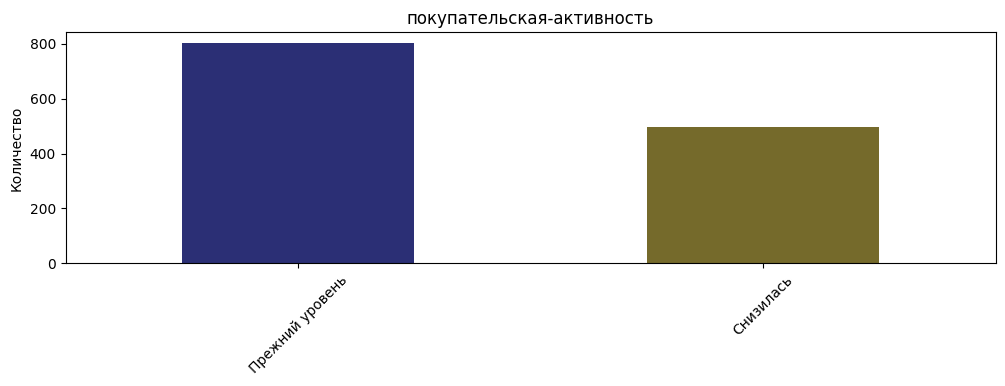

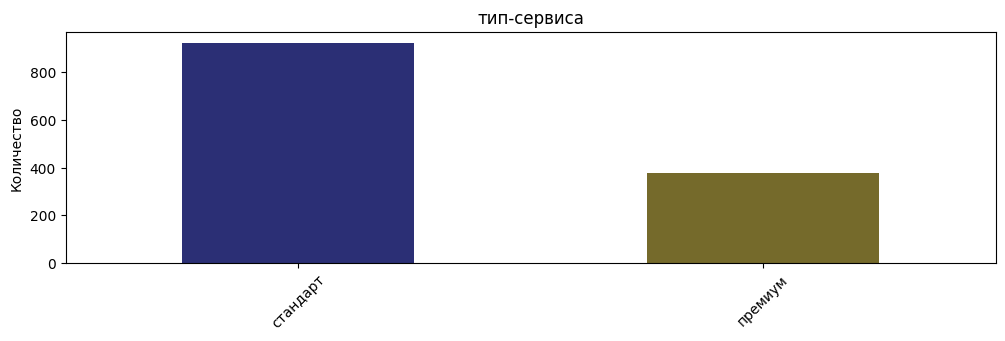

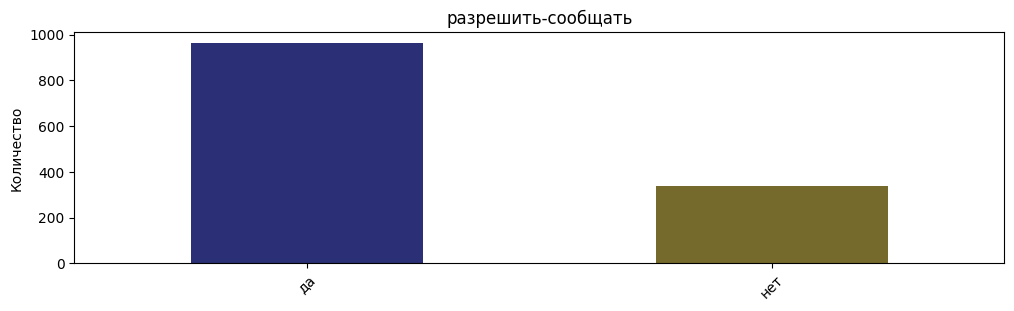

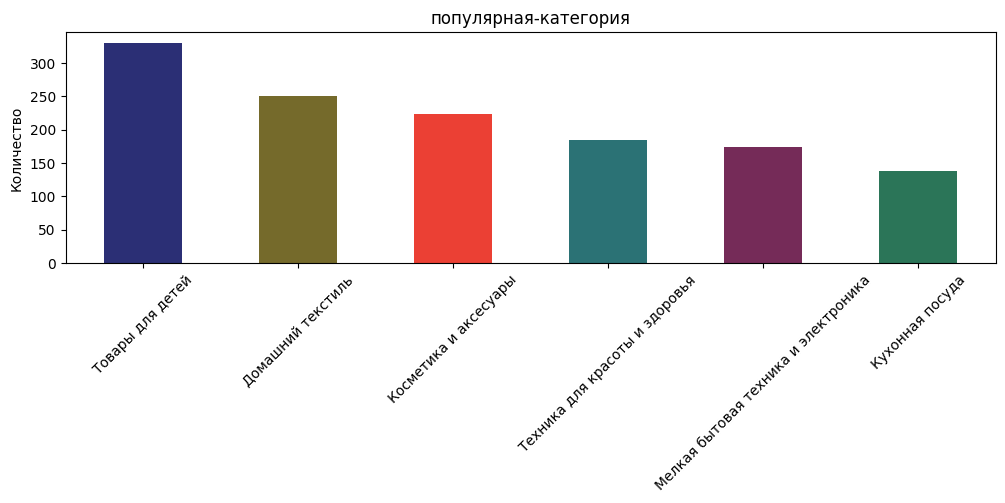

In [29]:
if DISPLAY_PLOTS:
    for num_col in CatColumns.FILE.value:
        Diagram.category_plot(df.market.file, num_col)



**Распределение покупательской активности**:
- **Прежний уровень**: около 800 покупателей.
- **Снизилась**: около 500 покупателей.

**Распределение типов сервиса**:
- **Стандарт**: около 900 покупателей.
- **Премиум**: около 300 покупателей.

**Распределение по разрешению на получение уведомлений**:
- **Да**: около 900 покупателей.
- **Нет**: около 300 покупателей.

**Распределение по популярной категории товаров**:
- **Товары для детей**: наиболее популярная категория (около 320 покупателей).
- **Домашний текстиль**: вторая по популярности категория (около 250 покупателей).
- **Косметика и аксессуары**: около 220 покупателей.
- **Техника для красоты и здоровья**: около 190 покупателей.
- **Мелкая бытовая техника и электроника**: около 180 покупателей.
- **Кухонная посуда**: наименее популярная категория (около 150 покупателей).


#### Вывод

- большинство покупателей сохранили прежний уровень активности, однако значительная часть покупателей снизила активность.
- большинство клиентов пользуются стандартным уровнем сервиса, премиум-клиентов примерно треть от общего числа.
- большинство клиентов (около 75%) согласны получать уведомления и маркетинговые предложения.
- наиболее популярной категорией товаров среди покупателей являются товары для детей. Наименее популярна кухонная посуда.


### Числовые значения


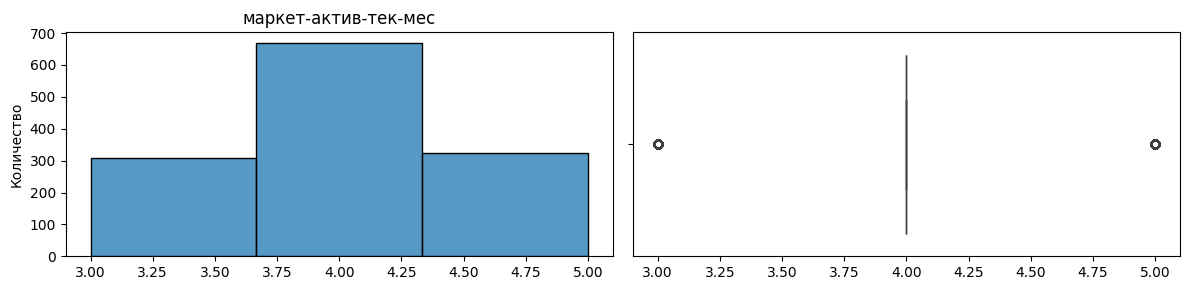

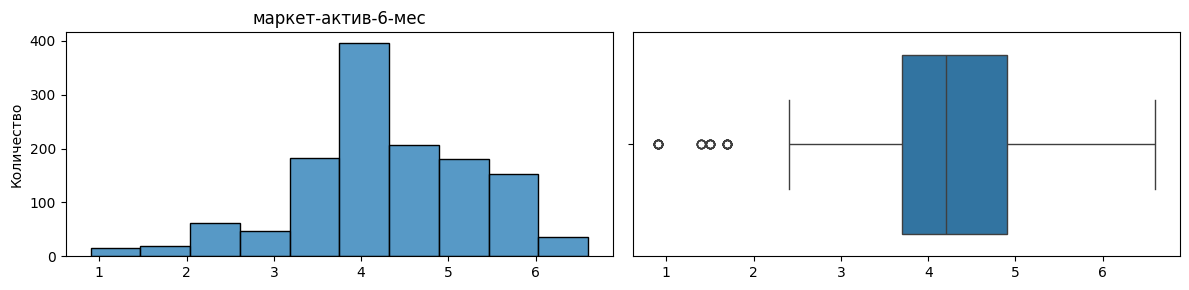

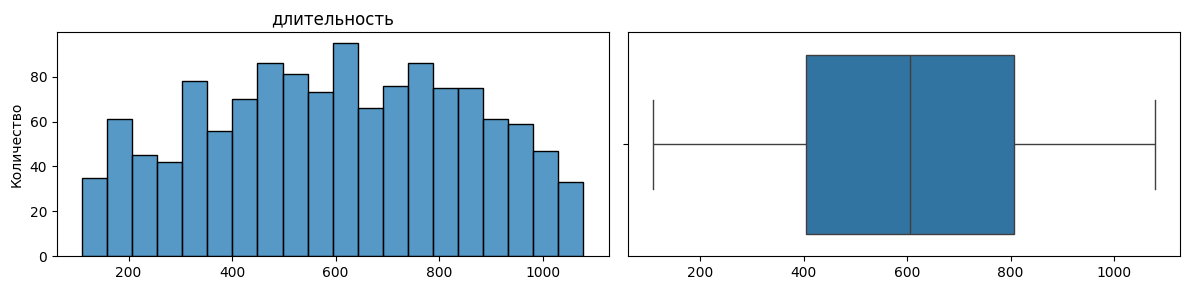

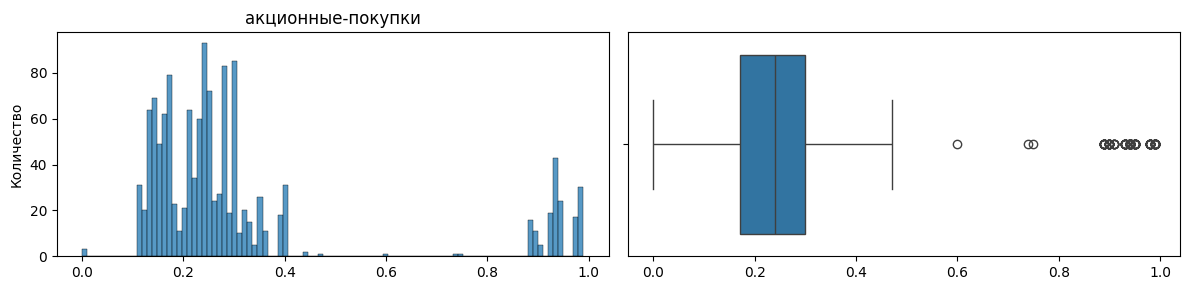

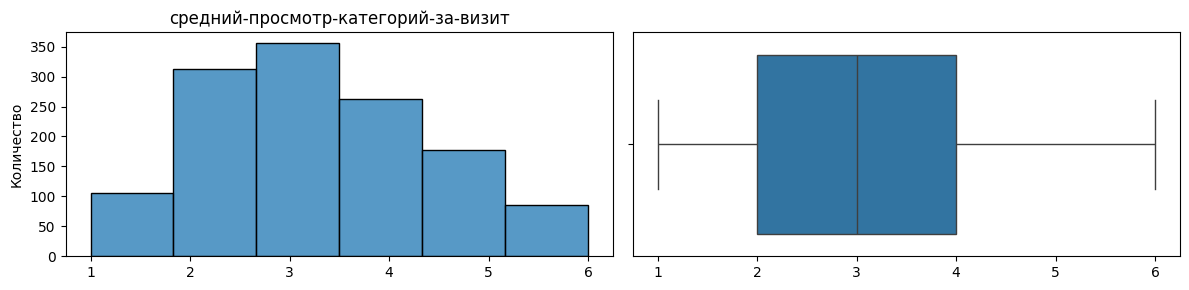

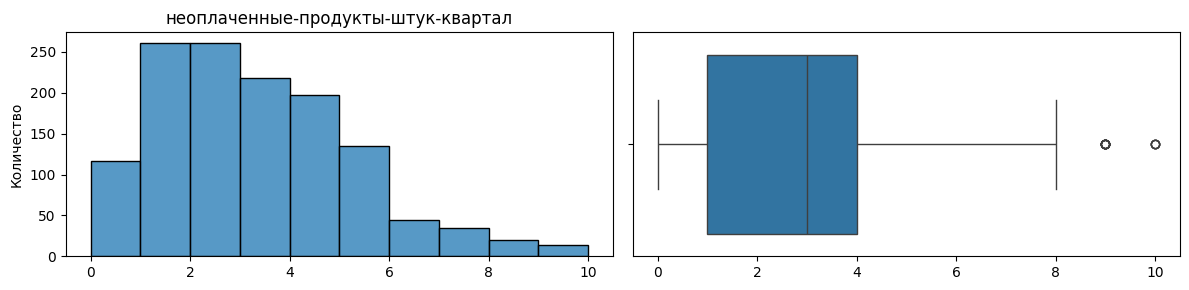

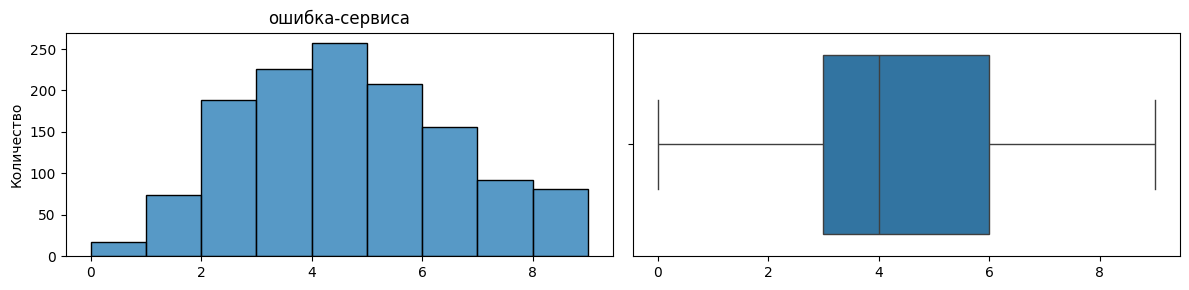

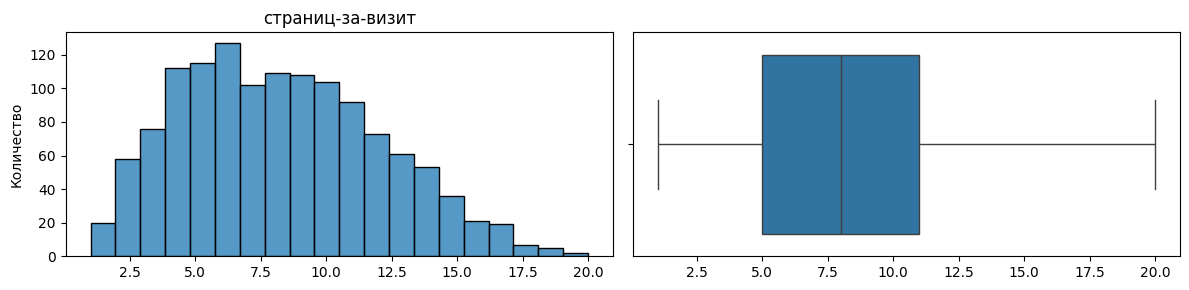

In [30]:
conf_bins = [3, 10, 20, 100, 6, 10, 9, 20]


if DISPLAY_PLOTS:
    for conf_bin, num_col in enumerate(NumColumns.FILE.value):
        Diagram.histogram_and_boxplot(
            df.market.file[num_col],
            conf_bins[conf_bin],
            title_histogram=num_col,
            title_boxplot=''
        )


**Маркет_актив_тек_мес**:
- Распределение: большинство значений сконцентрировано около значения 4.

**Маркет_актив_6_мес**:
- Распределение: большинство значений сосредоточено в диапазоне от 3 до 6, пик приходится на значение 4.
- Выбросы: присутствуют на уровнях ниже 2.

**Длительность**:
- Распределение: данные равномерно распределены в диапазоне от 0 до 1000 дней.
- Выбросы: не наблюдаются.

**Акционные_покупки**:
- Распределение (бимодальное): большинство значений сконцентрировано ниже 0.4, пик около 0.2.
- Выбросы: присутствуют на уровне выше 0.5.

**Средний_просмотр_категорий_за_визит**:
- Распределение: большинство значений сосредоточено в диапазоне от 1 до 6, пик приходится на значение 3.

**Неоплаченные_продукты_штук_квартал**:
- Распределение: большинство значений сосредоточено в диапазоне от 0 до 6.
- Выбросы: присутствуют на уровнях выше 8.

**Ошибка_сервиса**:
- Распределение: большинство значений сосредоточено в диапазоне от 2 до 16, пик около 4.

**Страниц_за_визит**:
- Распределение: большинство значений сосредоточено в диапазоне от 5 до 10, пик около 7.


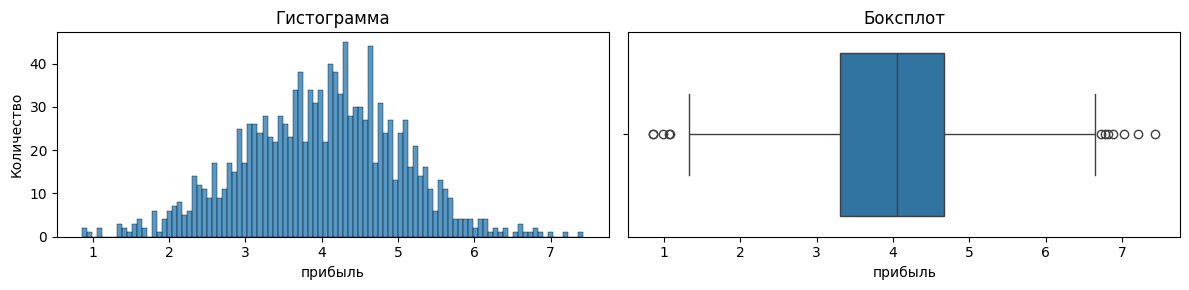

In [31]:
if DISPLAY_PLOTS:
    Diagram.histogram_and_boxplot(
        df.money[NumColumns.SALES.value[0]],
        100,
        x_label=NumColumns.SALES.value[0]
    )


Распределение: данные распределены в диапазоне от 1 до 7, с пиковой концентрацией значений около 4.
Выбросы: присутствуют на уровнях ниже `1.5` и выше `6.5`.


#### Вывод

**market_file.csv:**

- количество маркетинговых коммуникаций в текущем месяце у большинства клиентов составляет около 4.
- за последние 6 месяцев большинство клиентов получали в среднем около 4 маркетинговых коммуникаций в месяц.
- большинство клиентов зарегистрированы на сайте в течение от 200 до 800 дней.
- большинство клиентов совершают около 20% своих покупок по акциям.
- в среднем клиенты просматривают около 3 категорий за визит.
- большинство клиентов оставляют около 2 неоплаченных продуктов в корзине за квартал.
- большинство клиентов сталкиваются с около 4 ошибками сервиса.
- в среднем клиенты просматривают около 7 страниц за визит.

**money.csv:**
- большинство клиентов приносят прибыль в диапазоне от 3 до 5.
- Распределение прибыли клиентов имеет симметричное распределение с пиком около 4
- Присутствуют выбросы, которые могут требовать дополнительного анализа и возможного исключения или корректировки при моделировании.


### Таблица market_money.csv


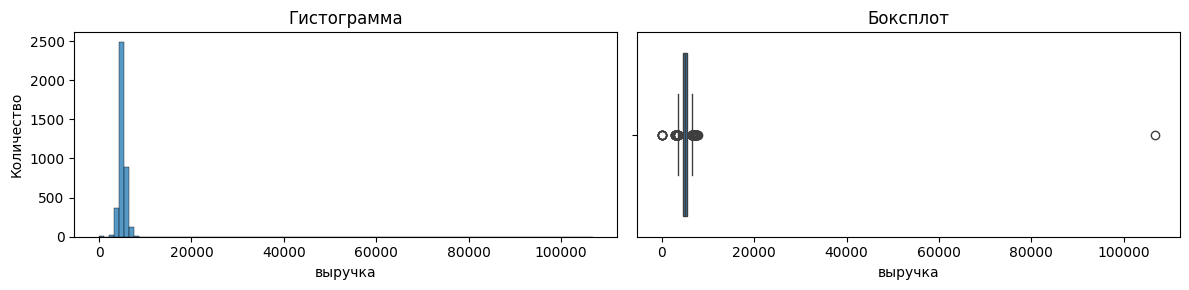

In [32]:
num_col_money = NumColumns.MONEY.value[0]
if DISPLAY_PLOTS:
    Diagram.histogram_and_boxplot(
        df.market.money[num_col_money], 100, x_label=num_col_money
    )

In [33]:
outlier_query = (
    (df.market.money[num_col_money] > K00) | (df.market.money[num_col_money] == 0.0)
)
outlier = df.market.money[outlier_query]

outlier_rows = df.market.money[df.market.money['id'].isin(outlier['id'])]


outlier_rows


,id,период,выручка
0,215348,препредыдущий-месяц,0.0
1,215348,текущий-месяц,3293.1
2,215348,предыдущий-месяц,0.0
27,215357,текущий-месяц,5986.3
28,215357,препредыдущий-месяц,0.0
29,215357,предыдущий-месяц,0.0
33,215359,текущий-месяц,4735.0
34,215359,предыдущий-месяц,0.0
35,215359,препредыдущий-месяц,0.0
96,215380,препредыдущий-месяц,5051.0


In [34]:
drop_ids = list(outlier_rows['id'].unique())

df.market.money.drop(outlier_rows.index, inplace=True)

drop_ids

[215348, 215357, 215359, 215380]

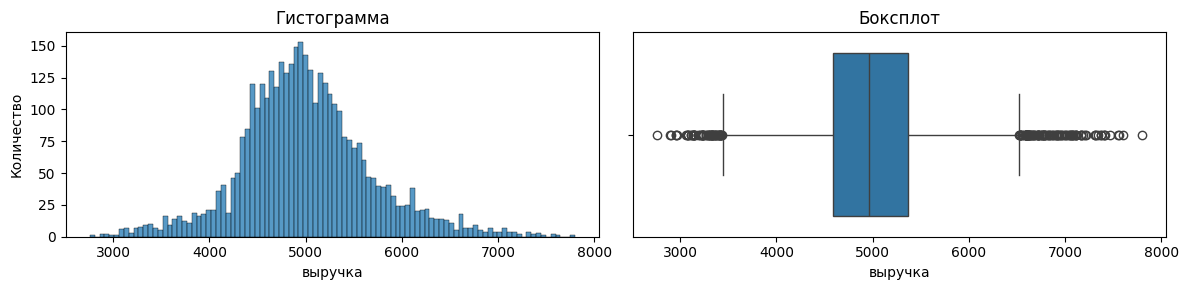

In [35]:
if DISPLAY_PLOTS:
    Diagram.histogram_and_boxplot(
        df.market.money[num_col_money], 100, x_label=num_col_money
    )



### Вывод

- Выбросы присутствуют на уровнях ниже 3500 и выше 6500;
- большинство клиентов приносят выручку в диапазоне от 4500 до 5500;
- данные распределены в диапазоне от 3000 до 8000, с пиковой концентрацией значений около 5000.


### Таблица market_time.csv


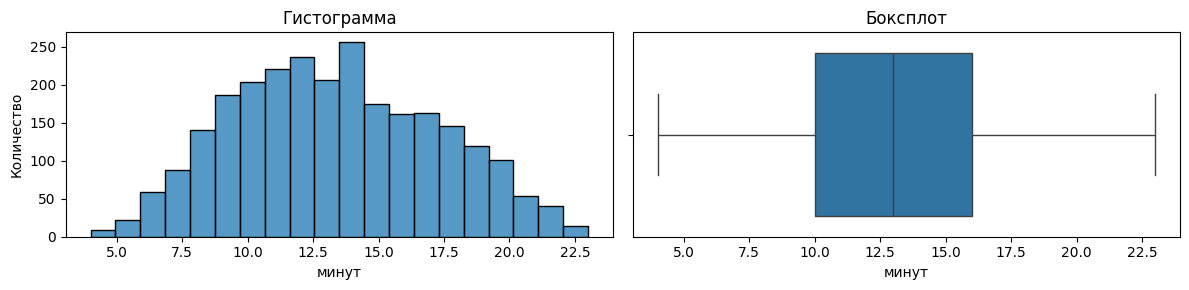

In [36]:
num_col_time = NumColumns.TIME.value[0]
if DISPLAY_PLOTS:
    Diagram.histogram_and_boxplot(
        df.market.time[num_col_time], 20, x_label=num_col_time
    )
    

#### Вывод

- Выбросы отсутствуют;
- данные распределены в диапазоне от 5 до 22.5 минут, с пиковой концентрацией значений около 12.5 минут;
- большинство клиентов проводят на сайте в среднем около 12.5 минут за визит.


## Объединение таблиц (Шаг 4.)

- Объедините таблицы `market_file.csv`, `market_money.csv`, `market_time.csv`. Данные о прибыли из файла `money.csv` при моделировании вам не понадобятся.
- Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.


### Реструктуризация таблиц


In [37]:
money_pivot = df.market.money.pivot_table(index='id', columns='период', values='выручка').reset_index()
money_pivot.columns = ['id', 'предыдущий-месяц', 'препредыдущий-месяц', 'текущий-месяц']

money_pivot.head(FEW)


,id,предыдущий-месяц,препредыдущий-месяц,текущий-месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4


In [38]:
time_pivot = df.market.time.pivot_table(index='id', columns='период', values='минут').reset_index()
time_pivot.columns = ['id', 'предыдущий-месяц-минут', 'текущий-месяц-минут']


time_pivot.head(FEW)


,id,предыдущий-месяц-минут,текущий-месяц-минут
0,215348,13.0,14.0
1,215349,12.0,10.0
2,215350,8.0,13.0


In [39]:

df.data = df.market.file.merge(money_pivot, on='id').merge(time_pivot, on='id')

# Set Index
# =========
df.data.set_index('id', inplace=True)
df.money.set_index('id', inplace=True)


df.data.head(FEW).T


id,215349,215350,215351
покупательская-активность,Снизилась,Снизилась,Снизилась
тип-сервиса,премиум,стандарт,стандарт
разрешить-сообщать,да,нет,да
маркет-актив-6-мес,4.4,4.9,3.2
маркет-актив-тек-мес,4,3,5
длительность,819,539,896
акционные-покупки,0.75,0.14,0.99
популярная-категория,Товары для детей,Домашний текстиль,Товары для детей
средний-просмотр-категорий-за-визит,4,5,5
неоплаченные-продукты-штук-квартал,4,2,0


In [40]:
df.data.shape

(1296, 17)

In [41]:
df.data.dtypes


покупательская-активность               object
тип-сервиса                             object
разрешить-сообщать                      object
маркет-актив-6-мес                     float64
маркет-актив-тек-мес                     int64
длительность                             int64
акционные-покупки                      float64
популярная-категория                    object
средний-просмотр-категорий-за-визит      int64
неоплаченные-продукты-штук-квартал       int64
ошибка-сервиса                           int64
страниц-за-визит                         int64
предыдущий-месяц                       float64
препредыдущий-месяц                    float64
текущий-месяц                          float64
предыдущий-месяц-минут                 float64
текущий-месяц-минут                    float64
dtype: object

## Корреляционный анализ (Шаг 5.)


'маркет-актив-6-мес, маркет-актив-тек-мес, длительность, акционные-покупки, средний-просмотр-категорий-за-визит, неоплаченные-продукты-штук-квартал, ошибка-сервиса, страниц-за-визит, предыдущий-месяц, препредыдущий-месяц, текущий-месяц, предыдущий-месяц-минут, текущий-месяц-минут, покупательская-активность_Снизилась, тип-сервиса_стандарт, разрешить-сообщать_нет'

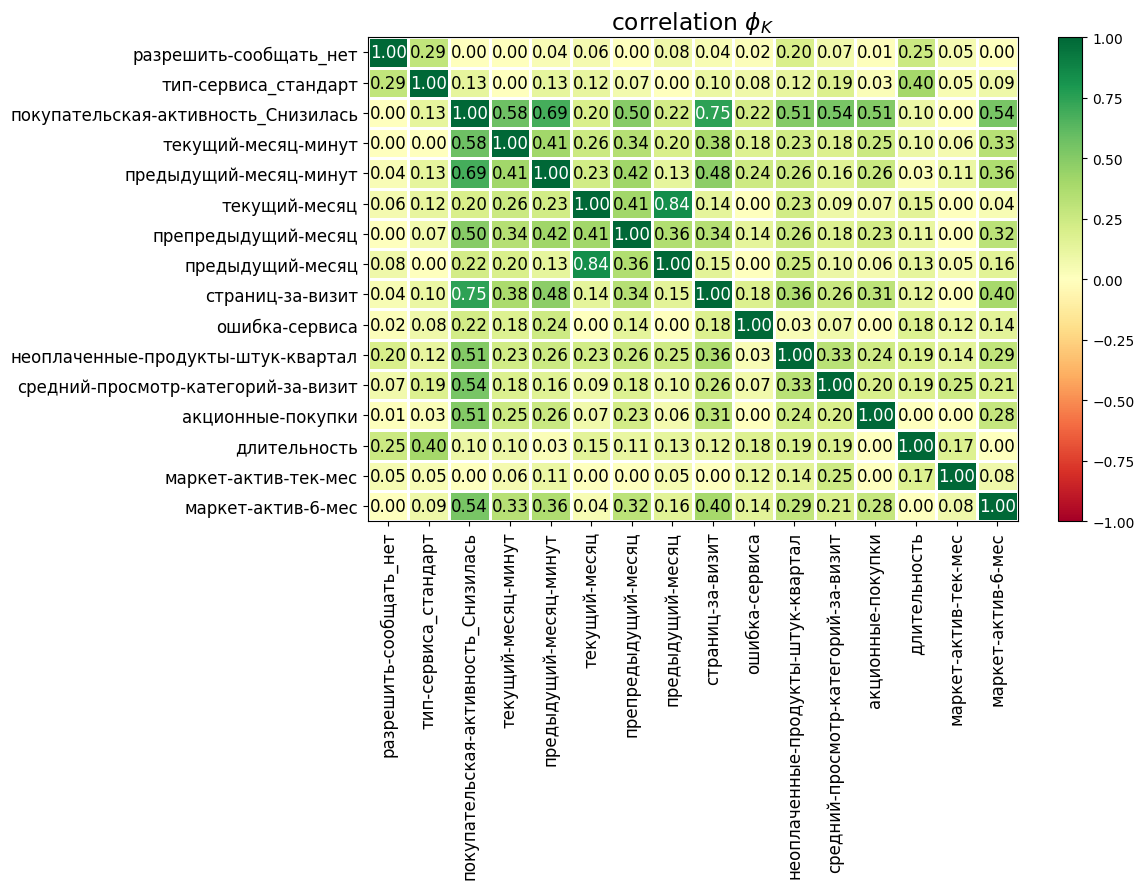

In [42]:
phik_data = df.data.copy().drop('популярная-категория', axis=1)

phik_data = pd.get_dummies(phik_data, drop_first=True)  # r3


phik_overview = phik_data[phik_data.columns].phik_matrix(interval_cols=phik_data.columns)


plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.2,
    figsize=(12, 9),
    top=50,
)


', '.join(list(phik_data.columns))


### Вывод

**Высокие корреляции**:
- `предыдущий-месяц` и `текущий-месяц`: Эти две переменные имеют высокую корреляцию `0.84`, что указывает на их тесную взаимосвязь. Это ожидаемо, так как текущий месяц и предыдущий месяц могут показывать схожие тенденции.
- `страниц-за-визит` и `покупательская-активность_Снизилась`: Эти две переменные имеют корреляцию `0.75`, что указывает на умеренно сильную связь.
- `страниц-за-визит` и `препредыдущий-месяц`: Эти переменные имеют корреляцию `0.34`.

**Низкие корреляции**:
- `длительность` в целом имеет низкие корреляции с другими переменными, что указывает на менее сильную связь с другими переменными.
- `маркет-актив-тек-мес` также показывает низкие корреляции, особенно с `текущий-месяц`, `предыдущий-месяц` и `препредыдущий-месяц`, что указывает на то, что текущие маркетинговые активности менее сильно коррелируют с месячными переменными.

**Средние корреляции**:
- `ошибка-сервиса` имеет корреляцию `0.24` с `предыдущий-месяц-минут` и `0.18` с `текущий-месяц-минут`.
- `акционные-покупки` показывают корреляции `0.31` с `страниц-за-визит` и `0.26` с `предыдущий-месяц`.



## Использование пайплайнов (Шаг 6.)

Примените все изученные модели. Для этого используйте пайплайны.

6.1 Во время подготовки данных используйте `ColumnTransformer`. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.

Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.

6.2 Обучите четыре модели: `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и `SVC()`. Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.

6.3 Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:

- использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
- использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

In [43]:
target_feature = 'покупательская-активность'
label_encoder = LabelEncoder()


X = df.data.drop([target_feature], axis=1)
y = label_encoder.fit_transform(df.data[target_feature])
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

numerical_features = (
    df.data.select_dtypes(include=['int64', 'float64']).columns.tolist()
)

categorical_features = [
    'тип-сервиса', 'разрешить-сообщать', 'популярная-категория'
]

numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
    ]
)

cat_lists = [df.data[feature].unique() for feature in categorical_features]

categorical_transformer_OHE = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, categories=cat_lists)),
    ]
)

categorical_transformer_OE = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(categories=cat_lists)),
    ]
)

preprocessor_OHE = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer_OHE, categorical_features),
    ],
    remainder='passthrough'
)

preprocessor_OE = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer_OE, categorical_features),
    ],
    remainder='passthrough'
)

pipeline_OHE = Pipeline([
    ('preprocessor', preprocessor_OHE),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

pipeline_OE = Pipeline([
    ('preprocessor', preprocessor_OE),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_distributions = [
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor': [preprocessor_OE]
    },
    {
        'model': [SVC(random_state=RANDOM_STATE, probability=True)],
        'model__C': [0.1, 0.2, 0.4, 0.6, 0.78, 0.8, 0.88, 1.0, 5.0, 10.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'model__C': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

search = RandomizedSearchCV(
    pipeline_OHE,
    param_distributions,
    n_iter=50,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
search.fit(X_train, y_train)

final_model = search.best_estimator_
y_pred = final_model.predict(X_test)

print(f'Best Model: {search.best_params_}')
print(classification_report(y_test, y_pred))

Best Model: {'preprocessor__num': StandardScaler(), 'model__C': 0.78, 'model': SVC(probability=True, random_state=42)}
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       201
           1       0.98      0.80      0.88       123

    accuracy                           0.92       324
   macro avg       0.93      0.89      0.91       324
weighted avg       0.92      0.92      0.91       324



In [44]:
search.best_score_


0.8302603386397973

In [45]:
f1 = f1_score(y_test, y_pred, average='binary')

print(f"F1-Score: {f1}")


F1-Score: 0.8789237668161435


Использование показателя F1-скора в качестве критерия оценки играет решающую роль. F1-скор помогает найти сбалансированный подход между точностью (Precision) и полнотой (Recall), что особенно важно для маркетинговых стратегий. Точность гарантирует, что маркетинговые ресурсы не тратятся впустую на клиентов, которые не нуждаются в вмешательстве, в то время как высокая полнота обеспечивает учет и целенаправленное обращение ко всем клиентам, действительно находящимся в зоне риска. Оптимизация F1-скора гарантирует, что маркетинговые мероприятия эффективно способствуют как повышению лояльности клиентов, так и экономии финансовых ресурсов.


In [46]:
probabilities = search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]

auc = roc_auc_score(y_test, probabilities_one)

print('ROC AUC', auc)


ROC AUC 0.911984791489706


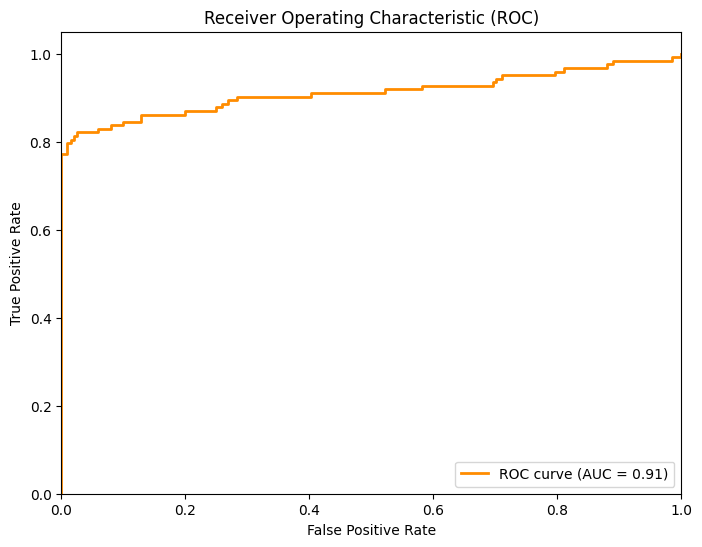

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")


plt.show()


## Анализ важности признаков (Шаг 7.)

7.1 Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP.

7.2 Сделайте выводы о значимости признаков:

- какие признаки мало значимы для модели;
- какие признаки сильнее всего влияют на целевой признак;
- как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.


In [48]:
shap.initjs()


  0%|          | 0/20 [00:00<?, ?it/s]

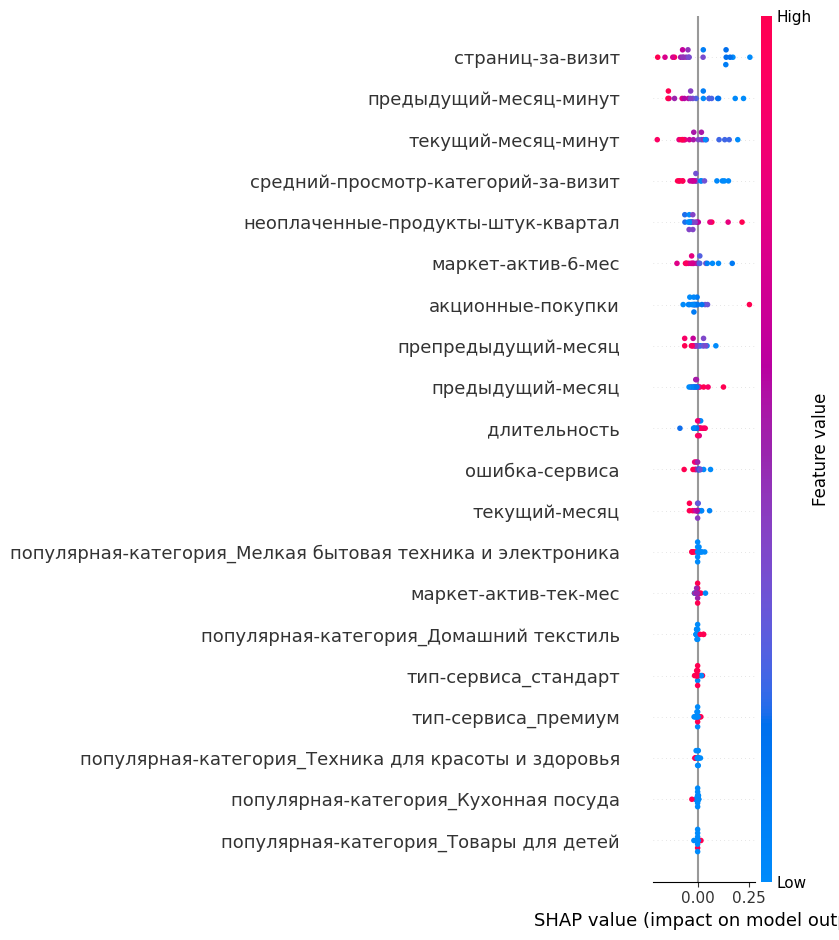

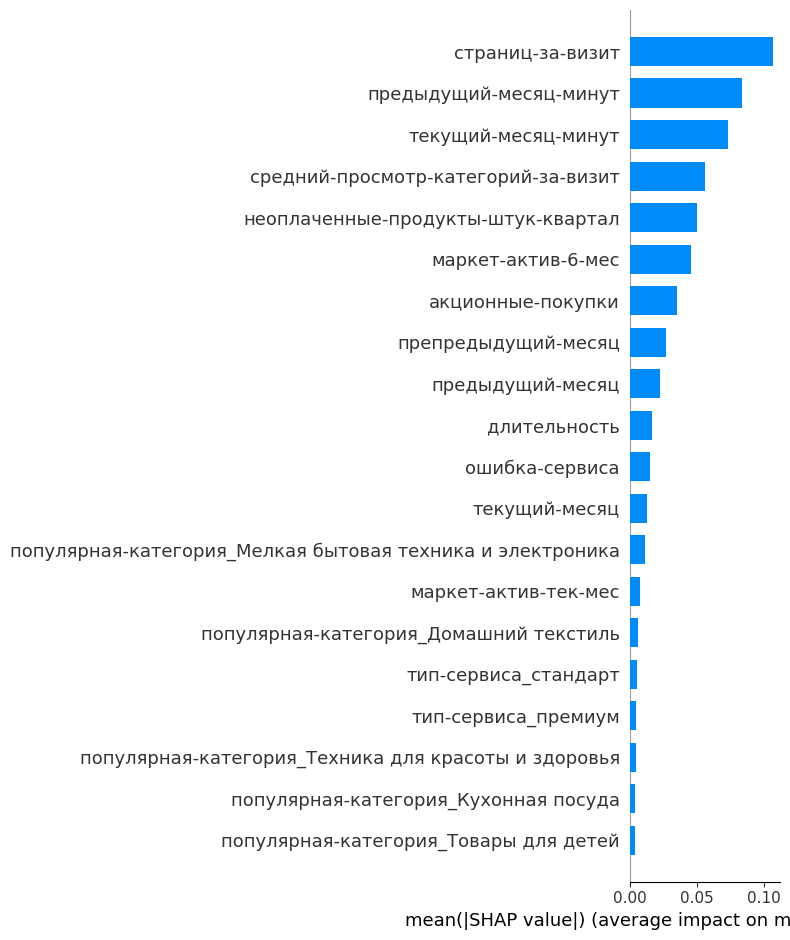

In [49]:
best_model = search.best_estimator_

X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)


if isinstance(best_model.named_steps['model'], SVC):
    X_train_sample = X_train_transformed[:SAMPLE_SIZE]
    explainer = shap.KernelExplainer(
        best_model.named_steps['model'].predict, X_train_sample
    )
    shap_values = explainer.shap_values(X_train_sample)

    categorical_features = (
        best_model.named_steps['preprocessor'].named_transformers_['cat']
        .named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
    )
    all_features = numerical_features + categorical_features
    shap.summary_plot(shap_values, X_train_sample, feature_names=all_features)
    shap.summary_plot(
        shap_values, X_train_sample, feature_names=all_features, plot_type='bar'
    )

else:
    raise NotImplementedError('Step 7 is only for SVC')



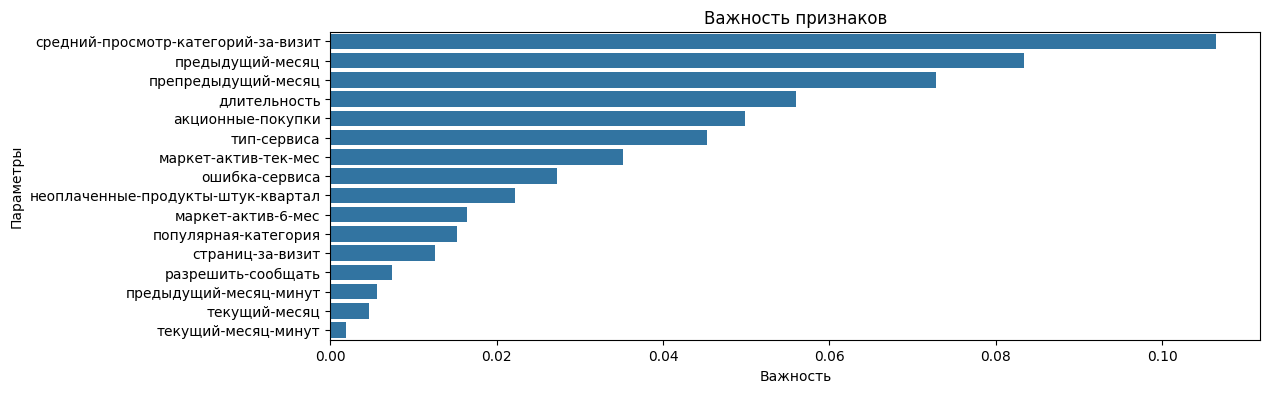

In [50]:
SELECT_MODEL = 3

important_features = None


if SELECT_MODEL == 1:  # KNN

    important_features = shap_values.abs.mean(0).values
    important_features = pd.DataFrame(
        list(zip(X_train.columns, important_features)),
        columns=['feature', 'importance']
    )
    important_features['importance'] = important_features['importance'].apply(
        lambda x: round(x[0], 4)
    )

elif SELECT_MODEL == 3:  # SVC

    important_features = np.abs(shap_values).mean(0)
    important_features = pd.DataFrame(
        list(zip(X_train.columns, important_features)),
        columns=['feature', 'importance']
    )
    important_features['importance'] = important_features['importance'].apply(
        lambda x: round(x, 4)
    )


important_features = important_features.sort_values(by='importance', ascending=False)
important_features = important_features[important_features['feature'] != 'id']

important_features.columns = ['Параметры', 'Важность']

# plot
plt.figure(figsize=(12, 4))
sns.barplot(x='Важность', y='Параметры', data=important_features)
plt.title('Важность признаков')

plt.show()


### Мало значимые признаки для модели

- Разрешить_сообщать_нет: Этот признак имеет минимальное влияние на модель.
- Тип_сервиса_стандарт: Этот признак также имеет небольшой вклад в модель.

### Признаки, которые сильнее всего влияют на целевой признак

- Страниц_за_визит: Это самый значимый признак для модели.
- Предыдущий_месяц_минут: Количество минут, проведенных на сайте в предыдущем месяце, имеет значительное влияние.
- Средний_просмотр_категорий_за_визит: Среднее количество просмотренных категорий за визит также существенно влияет на модель.
- Акционные_покупки: Этот признак имеет весомый вклад в модель.
- Маркет_актив_6_мес: Количество маркетинговых активностей за последние 6 месяцев важно для модели.
- Неоплаченные_продукты_штук_квартал: Количество неоплаченных продуктов в корзине за квартал также влияет на целевой признак.

### Использование наблюдений

**Моделирование:**
- Фокусироваться на значимых признаках для улучшения точности модели.
- Исключить мало значимые признаки для упрощения модели.

**Принятие бизнес-решений:**
- Целевые маркетинговые стратегии для активных клиентов.
- Улучшение пользовательского опыта (минимизация ошибок сервиса, упрощение оплаты).
- Сегментация клиентов для персонализированных предложений.
- Отслеживание ключевых показателей для быстрого реагирования на изменения.


## Сегментация покупателей (Шаг 8.)

8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

8.2 Выберите группу покупателей и предложите, как увеличить её покупательскую активность:

- Проведите графическое и аналитическое исследование группы покупателей.
- Сделайте предложения по работе с сегментом для увеличения покупательской активности.

8.3 Сделайте выводы о сегментах:

- какой сегмент вы взяли для дополнительного исследования,
- какие предложения вы сделали и почему.

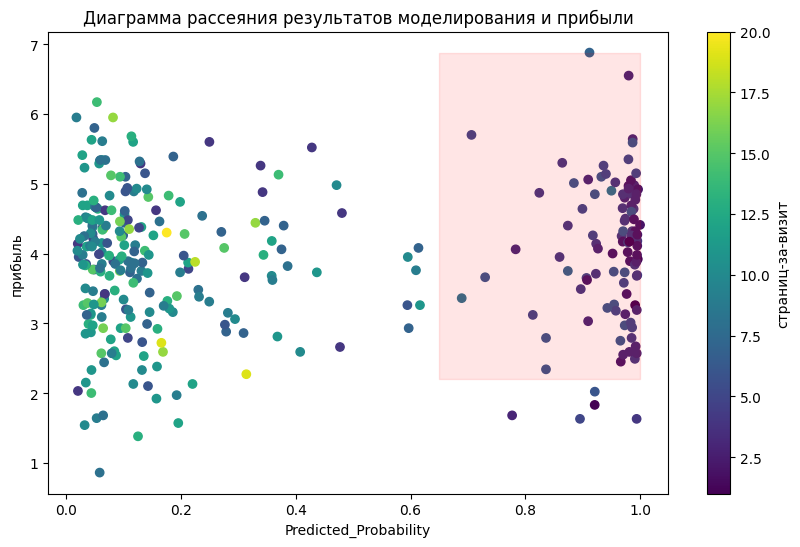

In [51]:
TRESHOLD_PROBA = 0.65
TRESHOLD_SALES = 2.2

SCATTER_GROUP = 'страниц-за-визит'


col_sales = NumColumns.SALES.value[0]

y_pred_proba = best_model.predict_proba(X_test)[:, 1]


df_segments: pd.DataFrame = X_test.copy()
df_segments = df_segments.join(df.money, on='id')

df_segments['Predicted_Probability'] = y_pred_proba

df_segments['Actual'] = y_test


plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_segments['Predicted_Probability'], 
    df_segments[col_sales],
    c=df_segments[SCATTER_GROUP],
    cmap='viridis'
)

plt.fill_betweenx(
    [TRESHOLD_SALES, max(df_segments[col_sales])], TRESHOLD_PROBA, 1, color='red', alpha=0.1
)

plt.title('Диаграмма рассеяния результатов моделирования и прибыли')
plt.xlabel('Predicted_Probability')
plt.colorbar(scatter, label=SCATTER_GROUP)
plt.ylabel(col_sales)


plt.show()


In [52]:
high_risk_segment = df_segments[df_segments['Predicted_Probability'] > TRESHOLD_PROBA]
high_risk_segment = high_risk_segment[high_risk_segment[col_sales] >TRESHOLD_SALES]

print(f"Количество клиентов в сегменте высокого риска: {len(high_risk_segment)}")


high_risk_segment.head().T


Количество клиентов в сегменте высокого риска: 95


id,215654,215501,215844,215375,215452
тип-сервиса,премиум,премиум,премиум,премиум,стандарт
разрешить-сообщать,нет,да,да,да,да
маркет-актив-6-мес,1.4,3.5,4.3,3.0,3.8
маркет-актив-тек-мес,4,3,4,4,4
длительность,684,1057,1041,558,756
акционные-покупки,0.94,0.35,0.99,0.89,0.9
популярная-категория,Товары для детей,Домашний текстиль,Кухонная посуда,Товары для детей,Товары для детей
средний-просмотр-категорий-за-визит,3,4,4,3,2
неоплаченные-продукты-штук-квартал,6,3,1,3,3
ошибка-сервиса,1,5,6,7,6


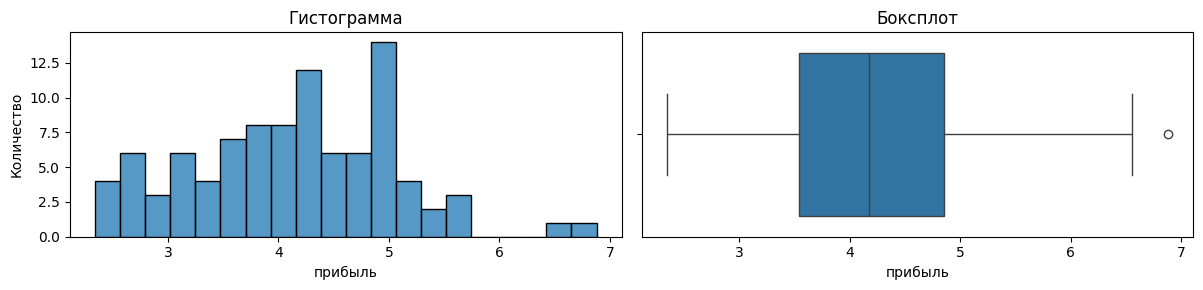

In [53]:
Diagram.histogram_and_boxplot(high_risk_segment[col_sales], 20, x_label=col_sales)


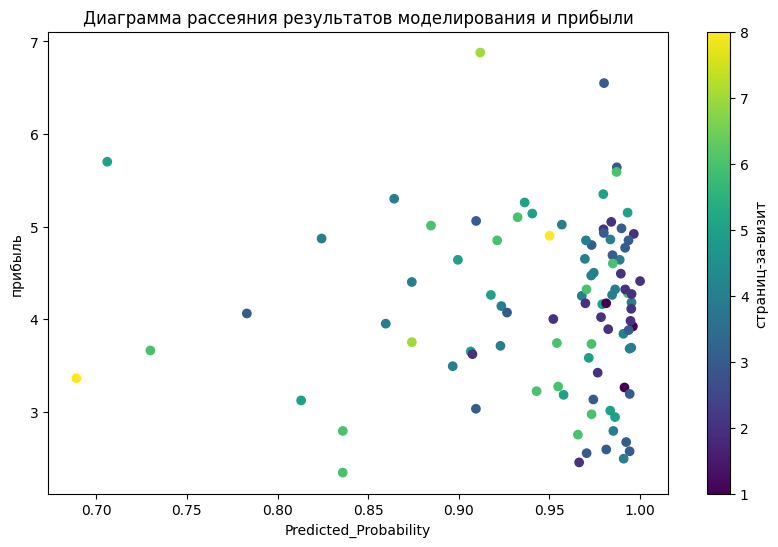

In [54]:

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    high_risk_segment['Predicted_Probability'], 
    high_risk_segment[NumColumns.SALES.value[0]],
    c=high_risk_segment[SCATTER_GROUP],
    cmap='viridis'
)
plt.title('Диаграмма рассеяния результатов моделирования и прибыли')
plt.xlabel('Predicted_Probability')
plt.ylabel(col_sales)
plt.colorbar(scatter, label=SCATTER_GROUP)

plt.show()


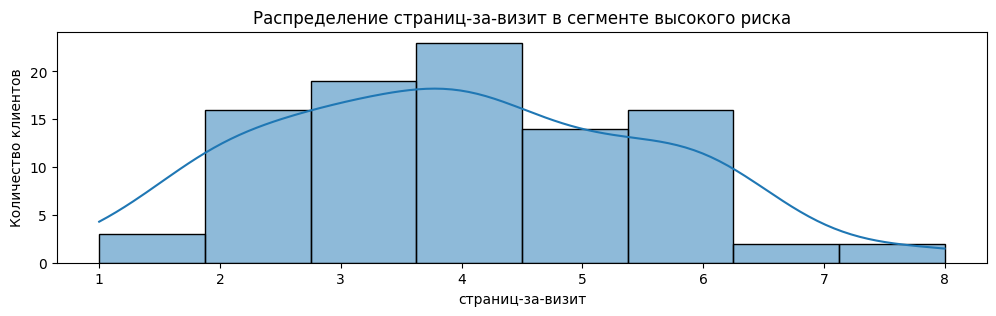

In [55]:
XY_SIZE = (12, 3)

plt.figure(figsize=XY_SIZE)
sns.histplot(high_risk_segment[SCATTER_GROUP], kde=True, bins=8)
plt.title(f'Распределение {SCATTER_GROUP} в сегменте высокого риска')
plt.xlabel(SCATTER_GROUP)
plt.ylabel('Количество клиентов')

plt.show()


### Предложения по увеличению покупательской активности

- Исправить технические ошибки на сайте.
- Усилить службу поддержки клиентов.
- Анализировать историю покупок для создания персонализированных предложений.
- Внедрить систему рекомендаций товаров.
- Отправлять напоминания о незавершенных покупках.
- Внедрить программы лояльности (бонусы, скидки).
- Проводить опросы для сбора обратной связи.
- Внедрить систему отзывов и оценок товаров.

### Выводы о сегментах

#### Выбранный сегмент для исследования

Сегмент клиентов с высокой вероятностью снижения покупательской активности.

#### Предложения и их обоснование

**Исправить ошибки на сайте, усилить службу поддержки.**

Почему: Уменьшение негативного опыта повысит удовлетворенность клиентов.

**Создавать персонализированные предложения, предоставлять скидки и бонусы.**

Почему: Персонализированные предложения увеличат интерес и активность клиентов.

**Внедрить программы лояльности, собирать обратную связь.**

Почему: Лояльность и обратная связь помогут лучше понимать и удовлетворять потребности клиентов.

## Общий вывод (Шаг 9.)

### Задача

Цель проекта заключалась в разработке модели, предсказывающей вероятность снижения покупательской активности клиентов интернет-магазина "В один клик" в следующие три месяца. Это позволит компании предлагать персонализированные предложения для удержания постоянных клиентов и увеличения их покупательской активности.

### Исходные данные и предобработка

Использовались несколько таблиц данных:
- **market_file.csv**: информация о поведении клиентов на сайте, коммуникациях и продуктовом поведении.
- **market_money.csv**: данные о выручке с клиентов.
- **market_time.csv**: время, проведенное клиентами на сайте.
- **money.csv**: среднемесячная прибыль клиентов.

Предобработка включала:
- Загрузку данных и проверку их соответствия описанию.
- Обработку пропущенных значений и конвертацию типов данных.
- Объединение таблиц в одну для моделирования.
- Кодирование категориальных признаков и масштабирование количественных признаков с помощью `ColumnTransformer`.

### Поиск лучшей модели

Были обучены и оценены следующие модели:
- KNeighborsClassifier
- DecisionTreeClassifier
- LogisticRegression
- SVC

Для каждой модели были использованы различные техники кодирования и масштабирования данных, а также проведен подбор гиперпараметров. Оценка моделей проводилась на основе метрик точности, полноты и F1-меры.

### Лучшая модель

Лучшей моделью оказалась **SVC**:
- F1-мера: 0.88

#### Выводы и дополнительные предложения для выбранного сегмента покупателей

Для сегмента клиентов с высокой вероятностью снижения покупательской активности предложены следующие меры:

1. **Улучшение качества сервиса:**
   - Исправить ошибки на сайте и усилить службу поддержки.
   - **Почему:** Это уменьшит негативный опыт и повысит удовлетворенность клиентов.

2. **Персонализированные предложения:**
   - Создавать персонализированные предложения, предоставлять скидки и бонусы.
   - **Почему:** Персонализированные предложения увеличат интерес и активность клиентов.

3. **Программы лояльности и сбор обратной связи:**
   - Внедрить программы лояльности, собирать обратную связь.
   - **Почему:** Лояльность и обратная связь помогут лучше понимать и удовлетворять потребности клиентов.
